#exploation14

## 데이터 불러오기

In [ ]:
import os

data_path = os.getenv('HOME')+'/aiffel/exp14/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


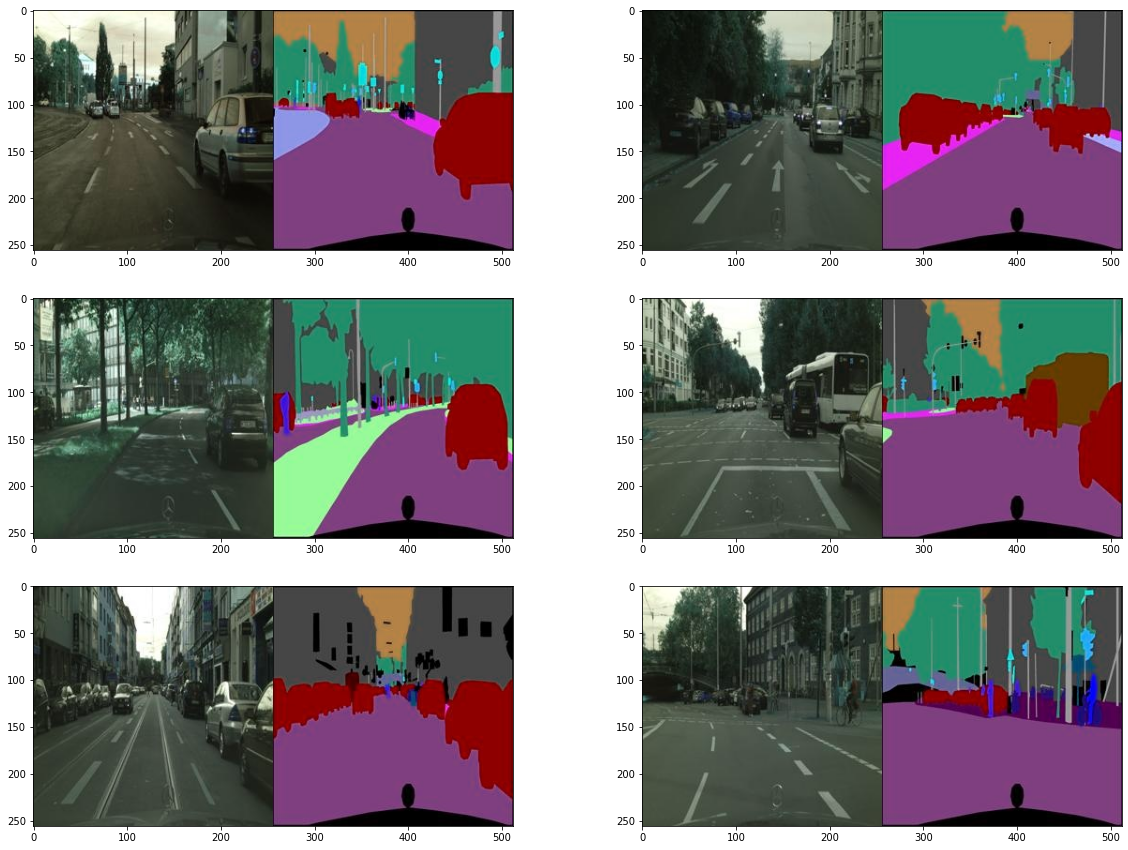

In [ ]:
#각각의 이미지들이 어떻게 생겼는지 확인
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.
(어떠한 방법을 사용했는지 적어주세요.)

In [ ]:
#이미지를 하나 열어 아래와 같이 크기를 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


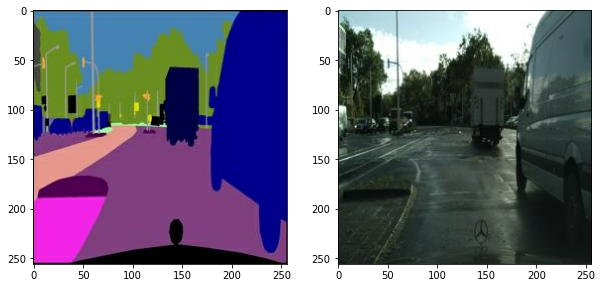

In [ ]:
#이미지를 나누어 보자
import tensorflow as tf

def normalize(x): #입력 이미지 x를 텐서플로우에서 사용하는 형태로 정규화
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1 #이미지의 픽셀값을 -1과 1 사이로 정규화

def denormalize(x): #정규화된 이미지 x를 역정규화하여 원래 이미지 형태로 변환
    x = (x+1)*127.5 #이미지의 픽셀값을 0과 255 사이로 역정규화
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path): #스케치와 컬러 이미지로 분리
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3) #이미지를 디코딩하고, 3개의 채널(RGB) 이미지로 변환

    w = tf.shape(img)[1] // 2 #이미지의 너비를 반으로 나누어 스케치와 컬러 이미지로 분리
    #sketch와 colored 나누는 부분
    sketch = img[:, w:, :]
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :]
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f) #해당 이미지를 스케치와 컬러 이미지로 분리하고 정규화

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
import tensorflow as tf

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다.
def apply_augmentation(sketch, colored):
    # 입력으로 받은 스케치 이미지와 컬러 이미지를 채널 방향(axis=-1)으로 합칩니다.
    stacked = tf.concat([sketch, colored], axis=-1)

    # 이미지에 패딩을 적용합니다.
    # 패딩은 두 가지 옵션을 랜덤하게 선택하여 적용합니다.
    _pad = tf.constant([[30,30],[30,30],[0,0]]) #상,하,좌,우 패딩 30설정
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT") # 반사(padding) 방식으로 패딩을 적용합니다.
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # 상수(padding) 값을 1로 설정하여 패딩을 적용합니다.

    # 이미지를 랜덤하게 크롭합니다.
    # 크롭된 이미지 크기는 [256, 256, 6]으로 설정합니다. (6은 합쳐진 채널 개수)
    out = image.random_crop(padded, size=[256, 256, 6])

    # 이미지를 좌우 또는 상하로 랜덤하게 뒤집습니다.
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    # 이미지를 랜덤하게 회전합니다.
    # 50% 확률로 90, 180, 270도 중 하나의 각도로 랜덤하게 회전합니다.
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32) #1~3 무작위
        out = image.rot90(out, k=degree) #k횟수만큼 out을 90도만큼 회전

    # 채널을 슬라이싱하여 스케치 이미지와 컬러 이미지를 분리하여 반환합니다.
    return out[...,:3], out[...,3:]

apply_augment에서는 패딩을 적용하여 crop(잘라내기)을 하고,
이미지를 상하좌우 뒤집고, 90,180,270도 랜덤하게 회전합니다.

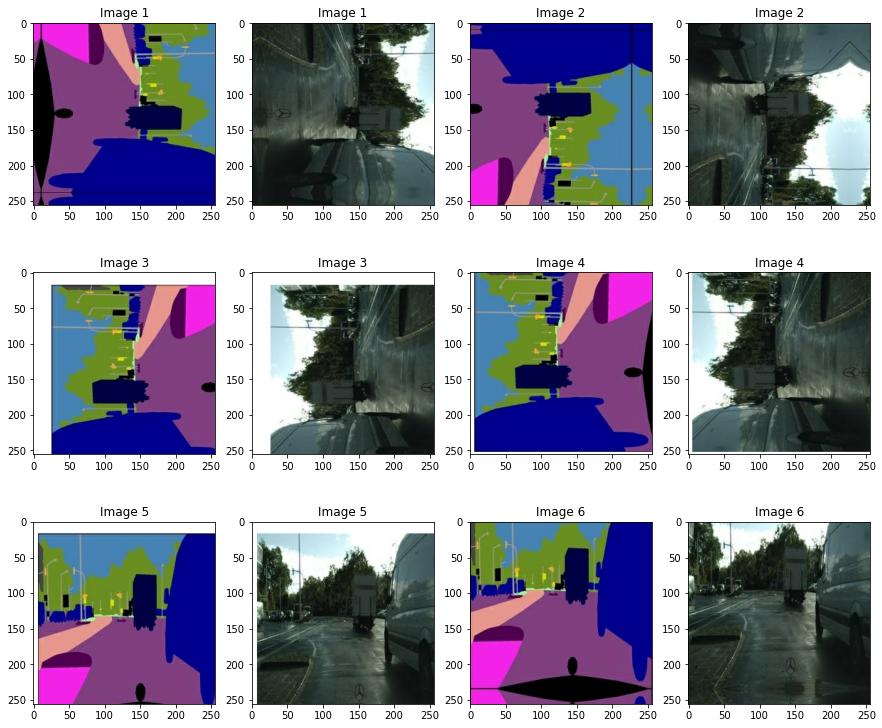

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored) #augmentation 수행

    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    #증강된 스케치 이미지 augmented_sketch를 시각화합니다. denormalize 함수를 사용하여 이미지를 원래 범위로 되돌려 놓은 후에 시각화합니다.
    plt.subplot(3,4,i+1);
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

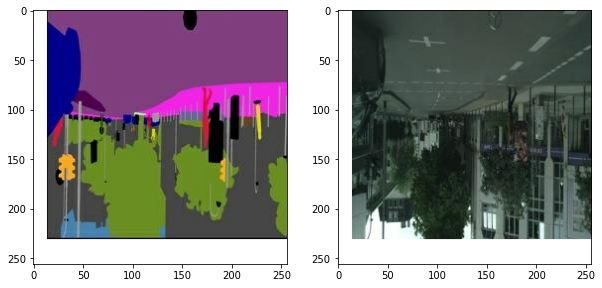

In [ ]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path) #이미지 로드
    sketch, colored = apply_augmentation(sketch, colored) #augmentation
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
#이미지 경로들을 리스트로 만들고, 이를 TensorFlow의 데이터셋으로 변환
train_images = train_images.map(get_train).shuffle(100).batch(4)
#데이터셋에 get_train 함수를 적용하여 데이터를 augmentation
#이후 랜덤하게 섞고(batch 단위로) 묶어서(4개씩) 학습 데이터로 만듭니다.

sample = train_images.take(1) # 학습 데이터에서 1개(batch)를 샘플링하여 가져옵니다.
sample = list(sample.as_numpy_iterator()) #샘플링된 학습 데이터를 리스트로 변환
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5
#샘플링된 학습 데이터에서 스케치 이미지와 컬러 이미지를 가져오고, 정규화를 해제하여 원래 범위로 되돌리기

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.

In [ ]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]

        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))

        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))

        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)

    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)

        features = features[:-1]

        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])

        x = self.last_conv(x)
        return x

    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_6[0][0]                    
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

In [ ]:
#descriminator
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act

        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)

        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None

    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)

        if self.use_bn:
            x = self.batchnorm(x)

        if self.act:
            x = self.lrelu(x)
        return x

print("✅")

✅


In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        '''
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        '''
        filters = [64,128,256,512,1]
        self.blocks = [] #layers.Concatenate()은 def call 부분에서 concat으로 결합하였다.


        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        for i, f in enumerate(filters):
            if i < 3:
                if i == 0:
                    self.blocks.append(DiscBlock(f, stride=2, custom_pad=False, use_bn=False, act=True))
                else:
                    self.blocks.append(DiscBlock(f, stride=2, custom_pad=False, use_bn=True,act=True))
            elif i == 3:
                  self.blocks.append(DiscBlock(f, stride=1, custom_pad=True, use_bn=True, act=True))
            else:
                  self.blocks.append(DiscBlock(f, stride=1, custom_pad=True, use_bn=False,act=False))
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, x, y):
        '''
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
        '''

    def call(self, x, y):
        out = tf.concat([x, y], axis=-1)  # 입력 데이터를 합칩니다.
        for block in self.blocks:
            out = block(out)
        return self.sigmoid(out)


    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

print("✅")


✅


1. 모델은 빈 목록 self.blocks = []로 시작합니다.
2. 그런 다음 for 루프를 통과하여 지정된 조건(stride, custom_pad, use_bn, act)에 따라 DiscBlock의 다른 인스턴스를 인스턴스화하고 self.blocks 목록에 추가합니다. .
3. 이 과정에서 입력 텐서 x와 y는 모델 흐름의 시작 부분에서 tf.concat()을 사용하여 연결됩니다.
4. 모든 레이어가 self.blocks에 추가되면 모델 아키텍처가 구성되고 그에 따라 DiscBlock 레이어 시퀀스를 통해 입력 데이터(x 및 y)를 처리할 수 있습니다.
5. 마지막으로 모델은 시그모이드 활성화 함수인 self.sigmoid(out)을 통해 연결되고 처리된 텐서의 출력을 반환합니다.

In [ ]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf.concat_1 (TFOpLambda)        (None, 256, 256, 6)  0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
disc_block_35 (DiscBlock)       (None, 128, 128, 64) 6144        tf.concat_1[0][0]          

## 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)

    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [ ]:
EPOCHS = 5

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)

        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0838                     
L1_loss:0.3355                     
Discriminator_loss:1.6145

EPOCH[1] - STEP[20]                     
Generator_loss:1.1391                     
L1_loss:0.2259                     
Discriminator_loss:1.2470

EPOCH[1] - STEP[30]                     
Generator_loss:0.7335                     
L1_loss:0.2676                     
Discriminator_loss:1.3533

EPOCH[1] - STEP[40]                     
Generator_loss:0.8162                     
L1_loss:0.2336                     
Discriminator_loss:1.3762

EPOCH[1] - STEP[50]                     
Generator_loss:0.8856                     
L1_loss:0.2115                     
Discriminator_loss:1.1345

EPOCH[1] - STEP[60]                     
Generator_loss:1.1181                     
L1_loss:0.1868                     
Discriminator_loss:1.1051

EPOCH[1] - STEP[70]                     
Generator_loss:0.6785                     
L1_loss:0.1923                    

## 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

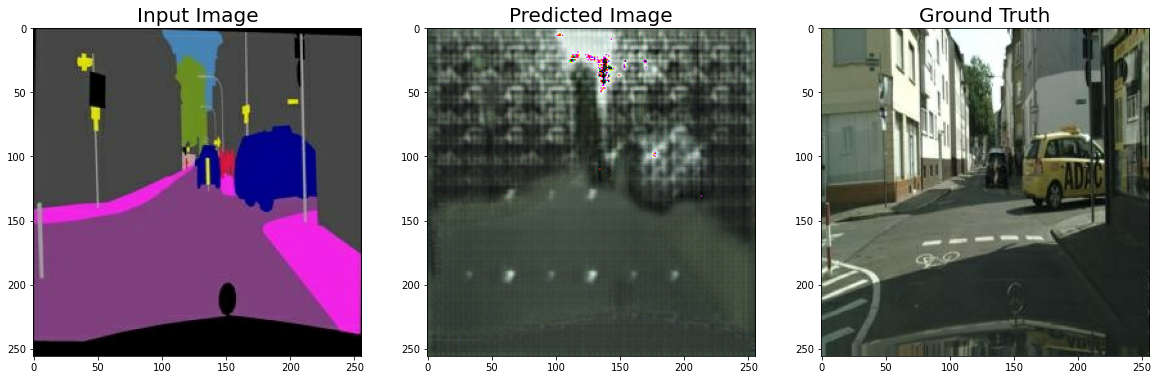

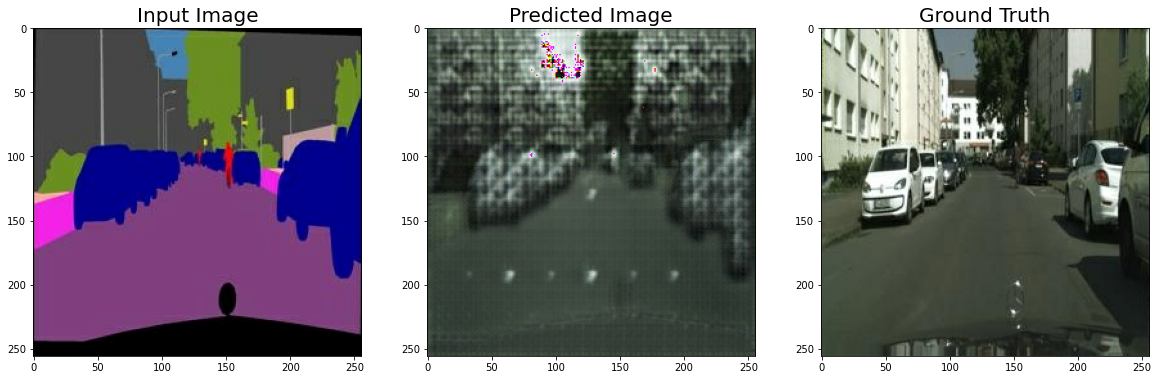

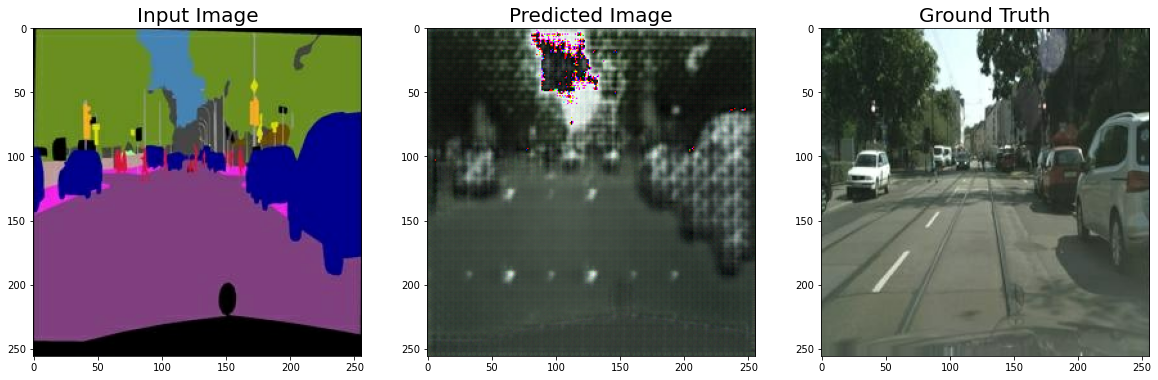

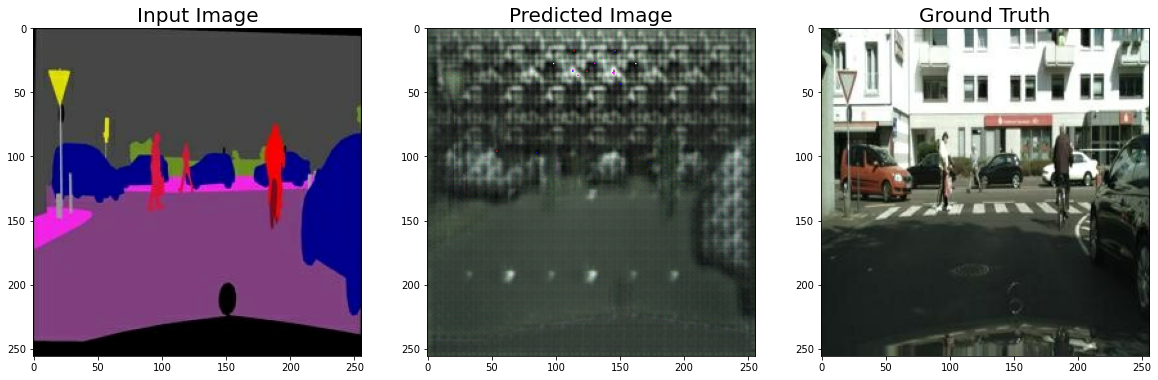

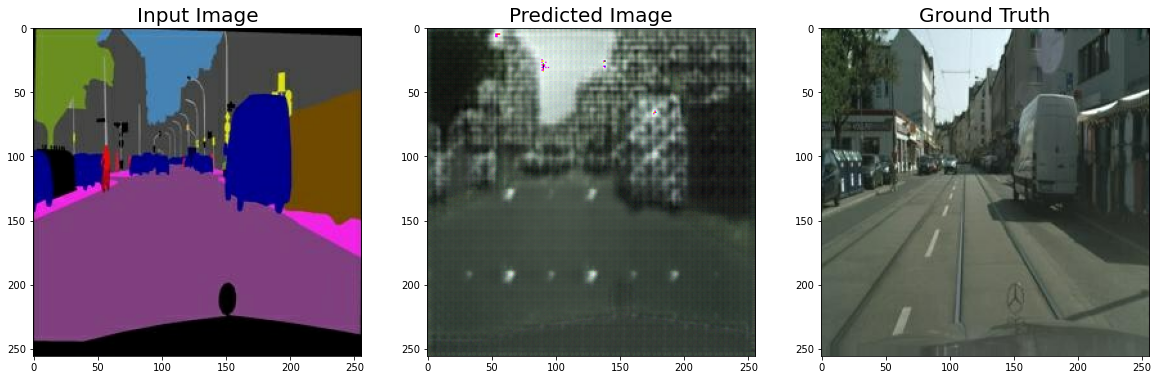

In [ ]:
test_path = os.getenv('HOME')+'/aiffel/exp14/cityscapes/val/'
for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=20)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=20)

## 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [ ]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)

        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:2.0186                     
L1_loss:0.2369                     
Discriminator_loss:0.6271

EPOCH[1] - STEP[200]                     
Generator_loss:1.4252                     
L1_loss:0.2405                     
Discriminator_loss:0.6526

EPOCH[2] - STEP[100]                     
Generator_loss:1.6775                     
L1_loss:0.2337                     
Discriminator_loss:0.6389

EPOCH[2] - STEP[200]                     
Generator_loss:3.6042                     
L1_loss:0.2233                     
Discriminator_loss:0.8413

EPOCH[3] - STEP[100]                     
Generator_loss:2.2077                     
L1_loss:0.2090                     
Discriminator_loss:0.2918

EPOCH[3] - STEP[200]                     
Generator_loss:0.7420                     
L1_loss:0.1938                     
Discriminator_loss:1.1059

EPOCH[4] - STEP[100]                     
Generator_loss:2.8105                     
L1_loss:0.2375             

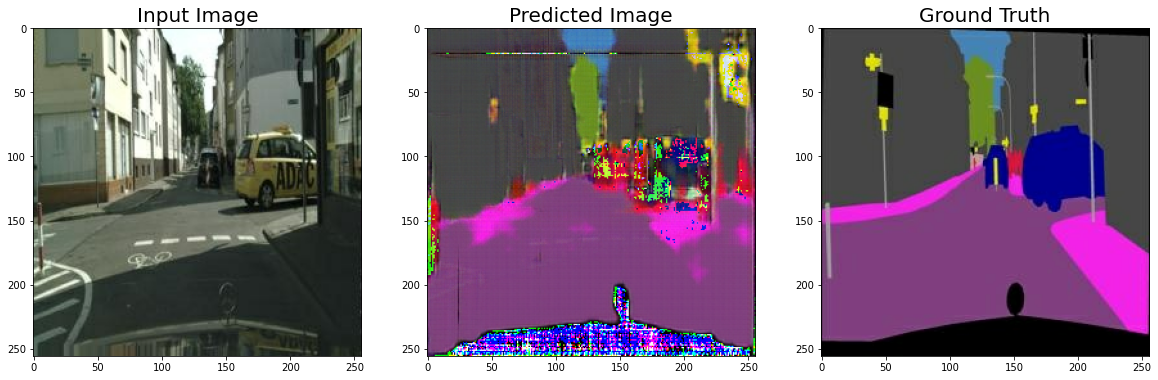

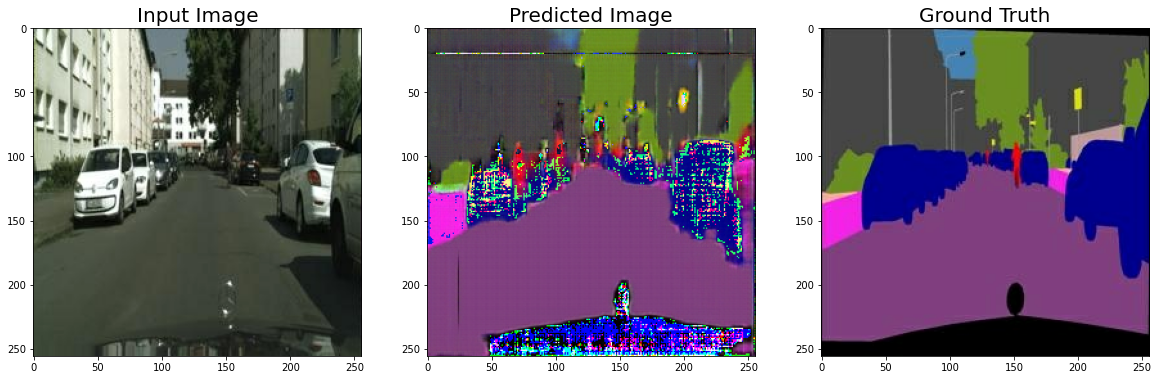

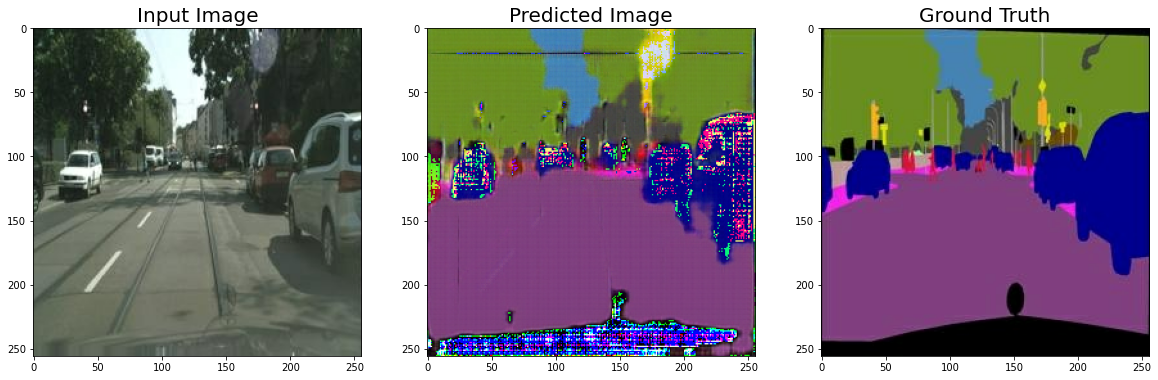

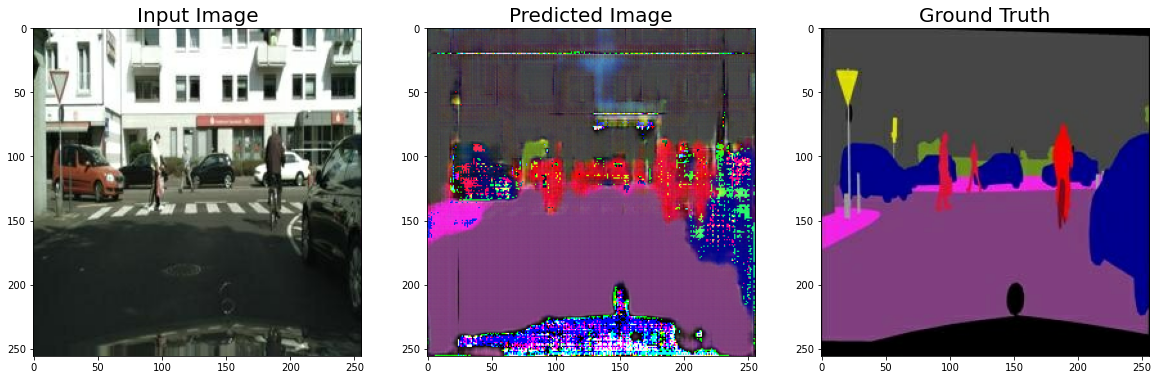

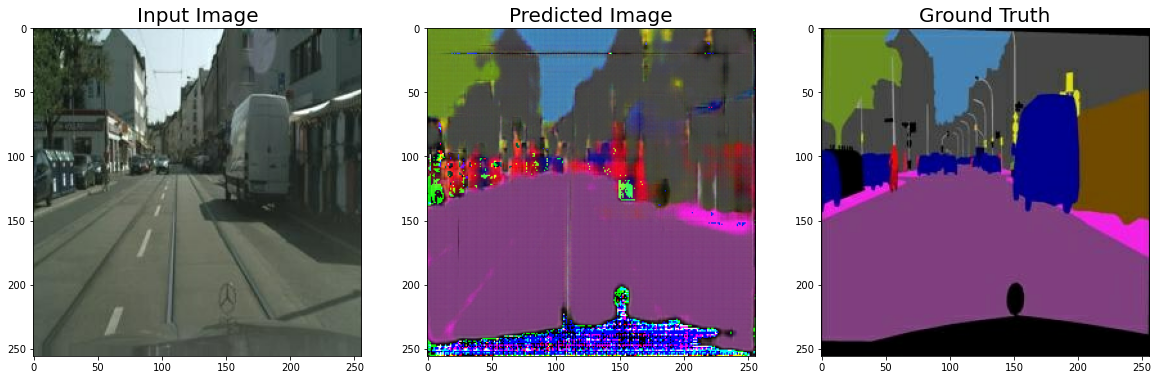

In [ ]:
test_path = os.getenv('HOME')+'/aiffel/exp14/cityscapes/val/'
for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=20)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=20)

[회고]
+ 대호님이 코드 sketch , colored 바꾼 부분 언급
+ 모델 개선 시킬 수 있는 방안 생각...

1. 일단 절대적인 Epoch 수를 늘리면 훨씬 더 정확하고 선명한 이미지를 생성할 수 있을 것 같음

2. Parameter
Optimizer, Loss function 등을 조정해보고 싶음

3. U-Net의 업그레이드 버전인 U-Net++ (Nested U-Net) 로 구현해보기


아래 코드는 pytorch 로 구현되어있는 거긴한데, 참조할만함.
https://github.com/wooseok-shin/code_implementation/blob/main/unet%2B%2B/model.py
pytorch 에 구현된 Pix2Pix


U-Net++이 U-Net과는 어떤 차이점이 존재하는지를 설명해보겠습니다. U-Net++은 U-Net과 크게 2가지의 차이점이 있습니다.

1. Re-designed skip pathways : U-Net에서도 Skip-Connection을 해주는 부분이 있었지만, U-Net++에서는 DenseNet의 아이디어를 차용하여 Encoder(수축 경로)와 Decoder(확장 경로)사이의 Semantic(의미적) Gap을 연결시켜 줍니다.

2. Deep Supervision : 각 브랜치의 출력(빨간색 선으로 표시된 부분)을 평균해서 최종 결과로서 사용하는 방법입니다.

[Ref : https://wsshin.tistory.com/2]